## ArcticHeat Alamo Deployments:
** 2018 **

Floats 9150, 9152, 9153 Deployed off of Sikuliaq

__pyversion__==3.6   
__author__==S.Bell

In [55]:
import datetime
print("Last run {0}".format(datetime.datetime.now()))

Last run 2018-09-05 06:54:13.794926


### connecting and basic information

In [74]:
import warnings
#remove the numpy/pandas/cython warnings
warnings.filterwarnings(action='ignore', message="numpy.dtype size changed,")

from erddapy import ERDDAP
import pandas as pd
import numpy as np

#server_url='http://downdraft.pmel.noaa.gov:8080/erddap'
server_url='http://ferret.pmel.noaa.gov/alamo/erddap'
e = ERDDAP(server=server_url)

Get only ALAMO Float datafiles - can be found by searching for arctic.

Searching on ALAMO provides an "alldata" response that would need to be filtered out

In [75]:
df = pd.read_csv(e.get_search_url(response='csv', search_for='arctic'))

In [76]:
alamos = df['Dataset ID'].values
print(alamos)

['arctic_heat_alamo_profiles_11010' 'arctic_heat_alamo_profiles_9058'
 'arctic_heat_alamo_profiles_9076' 'arctic_heat_alamo_profiles_9085'
 'arctic_heat_alamo_profiles_9115' 'arctic_heat_alamo_profiles_9116'
 'arctic_heat_alamo_profiles_9117' 'arctic_heat_alamo_profiles_9119'
 'arctic_heat_alamo_profiles_9121' 'arctic_heat_alamo_profiles_9150'
 'arctic_heat_alamo_profiles_9152' 'arctic_heat_alamo_profiles_9153'
 'arctic_heat_alamo_profiles_9154' 'arctic_heat_alamo_profiles_9155'
 'arctic_heat_alamo_profiles_9199']


In [77]:
kw = {
    'standard_name': 'sea_water_temperature',
    'min_lon': -180.0,
    'max_lon': -130.0,
    'min_lat': 65.0,
    'max_lat': 90.0,
    'min_time': '2018-01-10T00:00:00Z',
    'max_time': '2019-01-10T00:00:00Z',
    'cdm_data_type': 'trajectoryprofile'
}

In [78]:
variables = [e.get_var_by_attr(dataset_id=alamo, standard_name=lambda v: v is not None) for alamo in alamos]

common_variables = set(variables[0]).intersection(*variables[1:])

common_variables.update(['CYCLE_NUMBER']) 
#common_variables.remove('JULD')

In [79]:
constraints = {
    'longitude>=': kw['min_lon'],
    'longitude<=': kw['max_lon'],
    'latitude>=': kw['min_lat'],
    'latitude<=': kw['max_lat'],
    'time>=': kw['min_time'],
    'time<=': kw['max_time'],
}

download_url = e.get_download_url(
    dataset_id=alamos[7],
    protocol='tabledap',
    response='csv',
    variables=common_variables,
)

print(download_url)

http://ferret.pmel.noaa.gov/alamo/erddap/tabledap/arctic_heat_alamo_profiles_9119.csv?TEMP,PRES,longitude,PSAL,latitude,CYCLE_NUMBER,time


### retrieving erddap and plotting data

In [80]:
from requests.exceptions import HTTPError

dfs = {}
for alamo in alamos:
    print(alamo)
    try:
        e = ERDDAP(server=server_url,
            protocol='tabledap',
            response='csv'
        )
        e.constraints=constraints
        e.variables=common_variables
        e.dataset_id=alamo
    except HTTPError:
        print('Failed to generate url {}'.format(alamo))
        continue
    try:
        dfs.update({alamo: e.to_pandas(
                            index_col='time',
                            parse_dates=True,
                            skiprows=(1,)  # units information can be dropped.
                            )})
    except:
        pass

arctic_heat_alamo_profiles_11010
arctic_heat_alamo_profiles_9058
arctic_heat_alamo_profiles_9076
arctic_heat_alamo_profiles_9085
arctic_heat_alamo_profiles_9115
arctic_heat_alamo_profiles_9116
arctic_heat_alamo_profiles_9117
arctic_heat_alamo_profiles_9119
arctic_heat_alamo_profiles_9121
arctic_heat_alamo_profiles_9150
arctic_heat_alamo_profiles_9152
arctic_heat_alamo_profiles_9153
arctic_heat_alamo_profiles_9154
arctic_heat_alamo_profiles_9155
arctic_heat_alamo_profiles_9199


In [81]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter



In [82]:
### specify primary bulk figure parameters
fontsize = 20
labelsize = 16
#plotstyle = 'seaborn'
max_xticks = 10
plt.style.use('seaborn-ticks')
mpl.rcParams['svg.fonttype'] = 'none'
mpl.rcParams['ps.fonttype'] = 42 #truetype/type2 fonts instead of type3
mpl.rcParams['pdf.fonttype'] = 42 #truetype/type2 fonts instead of type3
mpl.rcParams['axes.grid'] = False
mpl.rcParams['axes.edgecolor'] = 'black'
mpl.rcParams['axes.linewidth'] = 1.5
mpl.rcParams['axes.labelcolor'] = 'black'
mpl.rcParams['grid.linestyle'] = '--'
mpl.rcParams['grid.linestyle'] = '--'
mpl.rcParams['xtick.major.size'] = 4
mpl.rcParams['xtick.minor.size'] = 1
mpl.rcParams['xtick.major.width'] = 2
mpl.rcParams['xtick.minor.width'] = 1
mpl.rcParams['ytick.major.size'] = 4
mpl.rcParams['ytick.minor.size'] = 1
mpl.rcParams['ytick.major.width'] = 2
mpl.rcParams['ytick.minor.width'] = 1
mpl.rcParams['ytick.direction'] = 'out'
mpl.rcParams['xtick.direction'] = 'out'
mpl.rcParams['ytick.color'] = 'black'
mpl.rcParams['xtick.color'] = 'black'

Re-hide me


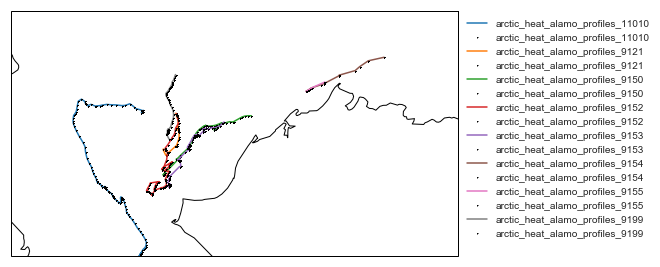

In [90]:

def make_map(projection=ccrs.PlateCarree()):
    fig, ax = plt.subplots(figsize=(8, 8),
                           subplot_kw=dict(projection=projection))
    if projection == ccrs.PlateCarree():
        gl = ax.gridlines(draw_labels=True)
        gl.xlabels_top = gl.ylabels_right = False
        gl.xformatter = LONGITUDE_FORMATTER
        gl.yformatter = LATITUDE_FORMATTER
    return fig, ax

projection=ccrs.LambertConformal(central_longitude=-160.0)
transformation=ccrs.PlateCarree()

land_50m = cfeature.NaturalEarthFeature('physical', 'land', '50m',
                                        edgecolor='face',
                                        facecolor='1.0')

dx = dy = 0.5
extent = [-176, -150, 67.5, 72.5]

fig,ax = make_map(projection=projection)
for alamo, df in dfs.items():
    if alamo in ['arctic_heat_alamo_profiles_11010']:
        print("Re-hide me")
    
    ax.plot(df['longitude'], df['latitude'], label=alamo, transform=transformation)
    ax.plot(df['longitude'], df['latitude'], '+k', markersize=1, label=alamo, transform=transformation)

leg = ax.legend(bbox_to_anchor=(1.45,1), loc='upper right')

ax.add_feature(land_50m)
ax.coastlines(resolution='50m')
ax.set_extent(extent)

or as a dynamic page seved in an iframe (needs to be a public page?)

In [66]:
def show_iframe(src):
    """Helper function to show HTML returns."""
    from IPython.display import HTML
    iframe = '<iframe src="{src}" width="100%" height="950"></iframe>'.format
    return HTML(iframe(src=src))

#show_iframe('https://www.pmel.noaa.gov')


## Depth v Time/Dive Profiles

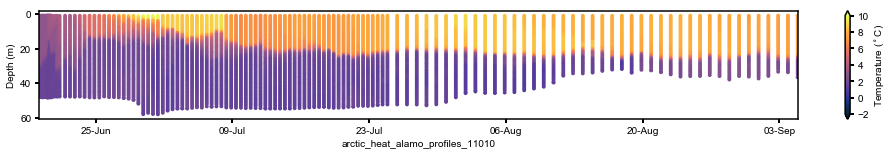

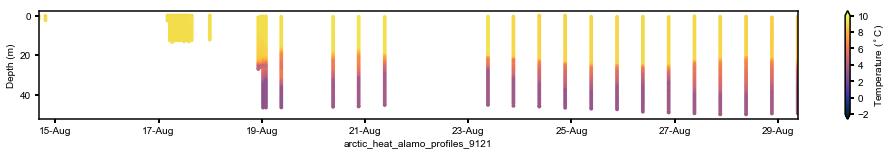

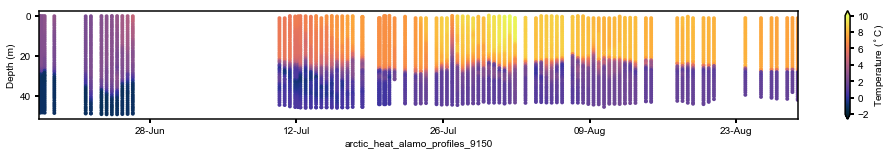

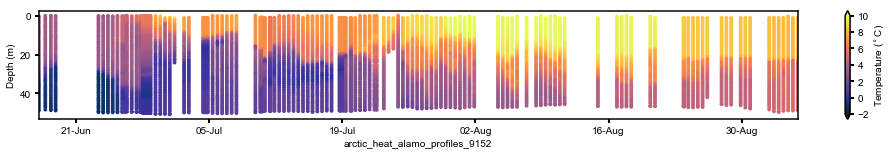

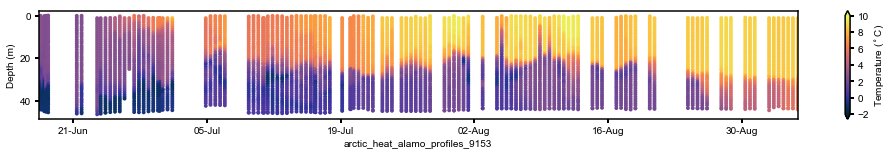

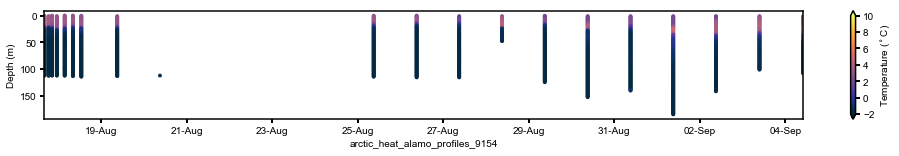

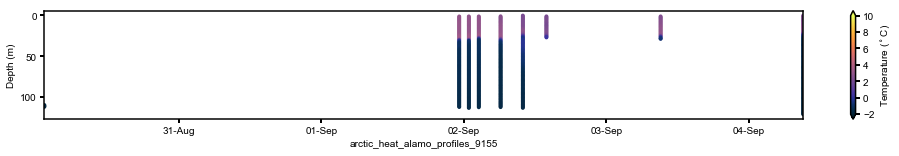

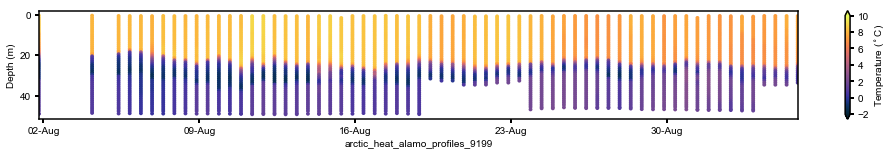

In [67]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import cmocean

for dfn, df in dfs.items():
    fig, ax = plt.subplots(figsize=(17, 2))
    cs = ax.scatter(df.index, df['PRES'], s=15, c=df['TEMP'], marker='o', edgecolor='none', vmin=-2, vmax=10, cmap=cmocean.cm.thermal)

    ax.invert_yaxis()
    ax.set_xlim(df.index[0], df.index[-1])
    xfmt = mdates.DateFormatter('%d-%b')
    ax.xaxis.set_major_formatter(xfmt)

    cbar = fig.colorbar(cs, orientation='vertical', extend='both')
    cbar.ax.set_ylabel('Temperature ($^\circ$C)')
    ax.set_ylabel('Depth (m)')
    ax.set_xlabel(dfn)

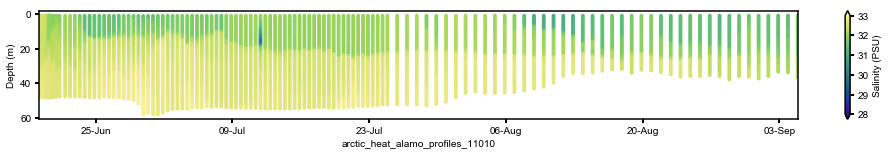

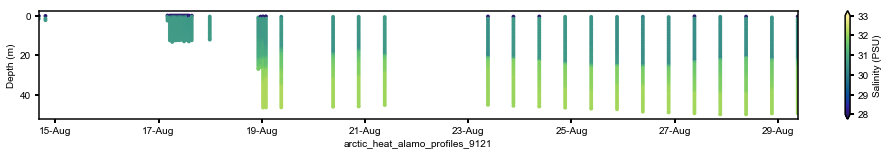

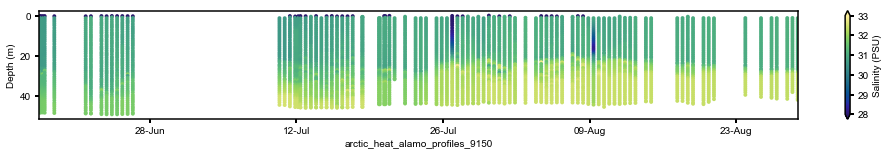

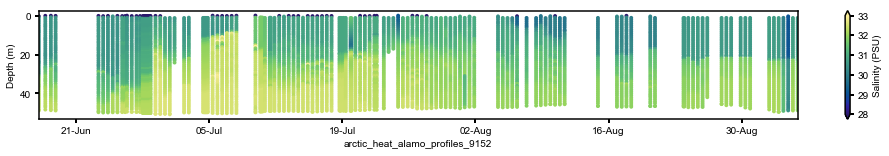

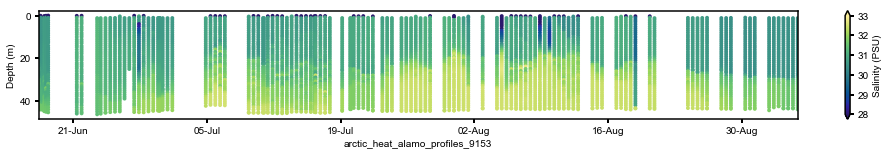

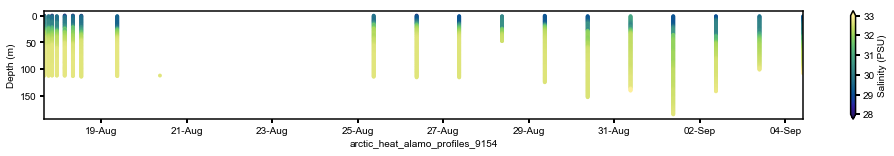

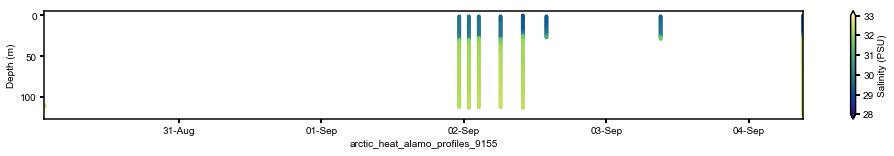

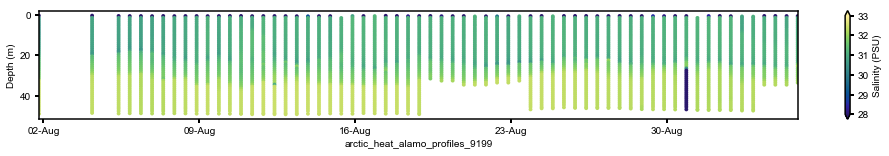

In [68]:
for dfn, df in dfs.items():
    fig, ax = plt.subplots(figsize=(17, 2))
    cs = ax.scatter(df.index, df['PRES'], s=15, c=df['PSAL'], marker='o', edgecolor='none', vmin=28, vmax=33,cmap=cmocean.cm.haline)

    ax.invert_yaxis()
    ax.set_xlim(df.index[0], df.index[-1])
    xfmt = mdates.DateFormatter('%d-%b')
    ax.xaxis.set_major_formatter(xfmt)

    cbar = fig.colorbar(cs, orientation='vertical', extend='both')
    cbar.ax.set_ylabel('Salinity (PSU)')
    ax.set_ylabel('Depth (m)')
    ax.set_xlabel(dfn)

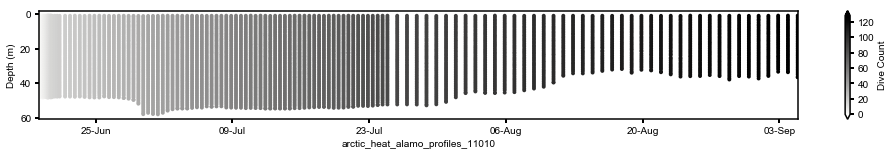

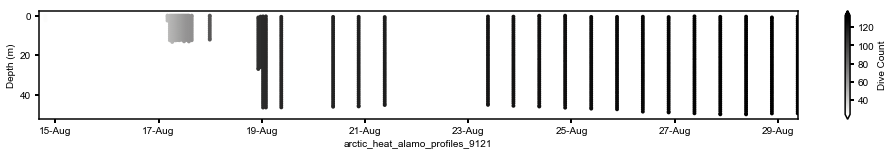

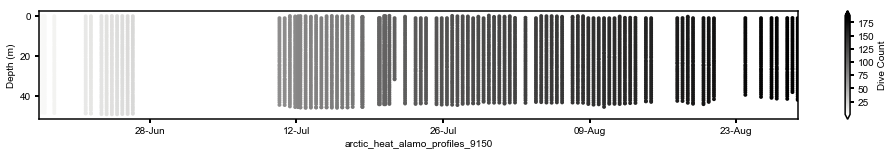

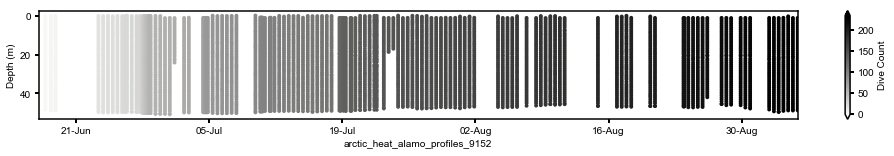

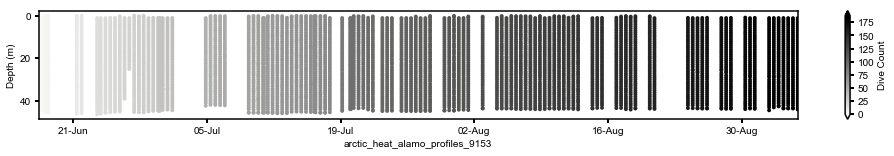

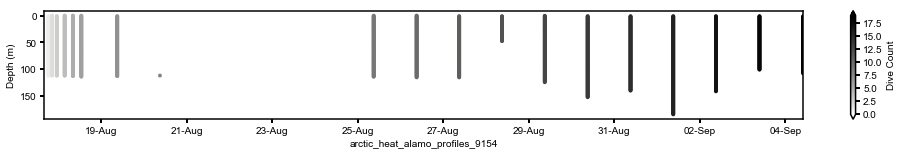

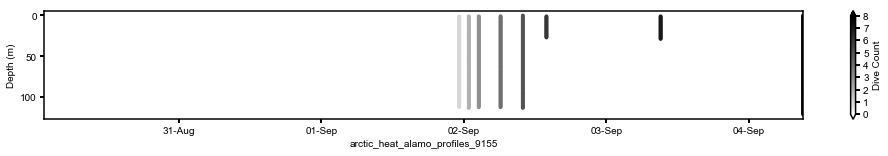

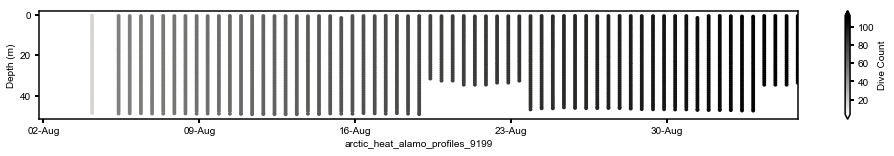

In [69]:
for dfn, df in dfs.items():
    fig, ax = plt.subplots(figsize=(17, 2))
    cs = ax.scatter(df.index, df['PRES'], s=15, c=df['CYCLE_NUMBER'], marker='o', edgecolor='none',cmap=cmocean.cm.gray_r)

    ax.invert_yaxis()
    ax.set_xlim(df.index[0], df.index[-1])
    xfmt = mdates.DateFormatter('%d-%b')
    ax.xaxis.set_major_formatter(xfmt)

    cbar = fig.colorbar(cs, orientation='vertical', extend='both')
    cbar.ax.set_ylabel('Dive Count')
    ax.set_ylabel('Depth (m)')
    ax.set_xlabel(dfn)

/Users/bell/anaconda2/envs/py36/lib/python3.6/site-packages/ipykernel/__main__.py:12: RuntimeWarning: Mean of empty slice


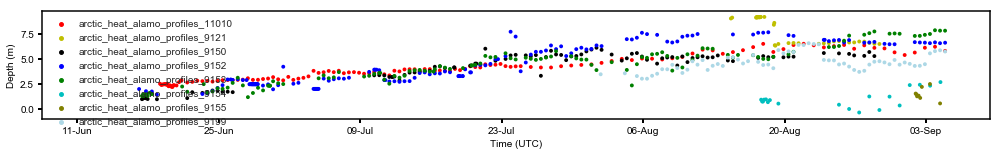

In [70]:
#depth averaged temp - interpolate to 1m bins before averaging
colors = ['r','y','k','b','g','c','olive','lightblue','grey']
ccount=0
legend_label=[]

fig, ax = plt.subplots(figsize=(17, 2))
for dfn, df in dfs.items():
    fg = df.groupby('CYCLE_NUMBER')

    for ind,fgi in enumerate(fg.groups):
        IntTemp = np.interp(np.arange(0,50,1),fg.get_group(fgi)['PRES'], fg.get_group(fgi)['TEMP'], left=np.nan, right=np.nan)
        cs = ax.scatter(fg.get_group(fgi).index[0], np.nanmean(IntTemp), s=15, c=colors[ccount], marker='o', edgecolor='none')

    xfmt = mdates.DateFormatter('%d-%b')
    ax.xaxis.set_major_formatter(xfmt)

    ax.set_ylabel('Depth (m)')
    ax.set_xlabel('Time (UTC)')
    ccount+=1
    
    legend_label.append(dfn)

ax.legend(legend_label)
leg = ax.get_legend()
for i in range(0,len(legend_label),1):
    leg.legendHandles[i].set_color(colors[i])


This is not biased due to sample frequency, but it will only give the value in the region of the column measured (so incomplete profiles are not interpolated to the top and bottom)

### Missing GPS Fixes

These profiles do not come with a latitude, longitude or timestamp (but linear interpolation from previous points may be ok)

Don't index on time, don't constrain any variables, plot as a function of cycle number

In [71]:
from requests.exceptions import HTTPError

dfs = {}
for alamo in alamos:
    print(alamo)
    try:
        e = ERDDAP(server=server_url,
            protocol='tabledap',
            response='csv'
        )
        e.variables=common_variables
        e.dataset_id=alamo
    except HTTPError:
        print('Failed to generate url {}'.format(alamo))
        continue
    try:
        dfs.update({alamo: e.to_pandas(
                            parse_dates=True,
                            skiprows=(1,)  # units information can be dropped.
                            )})
    except:
        pass

arctic_heat_alamo_profiles_11010
arctic_heat_alamo_profiles_9058
arctic_heat_alamo_profiles_9076
arctic_heat_alamo_profiles_9085
arctic_heat_alamo_profiles_9115
arctic_heat_alamo_profiles_9116
arctic_heat_alamo_profiles_9117
arctic_heat_alamo_profiles_9119
arctic_heat_alamo_profiles_9121
arctic_heat_alamo_profiles_9150
arctic_heat_alamo_profiles_9152
arctic_heat_alamo_profiles_9153
arctic_heat_alamo_profiles_9154
arctic_heat_alamo_profiles_9155
arctic_heat_alamo_profiles_9199


## All Available ALAMO Floats - as divenumber

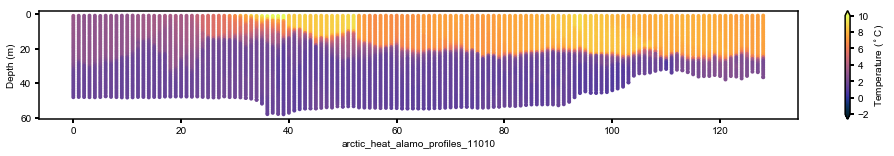

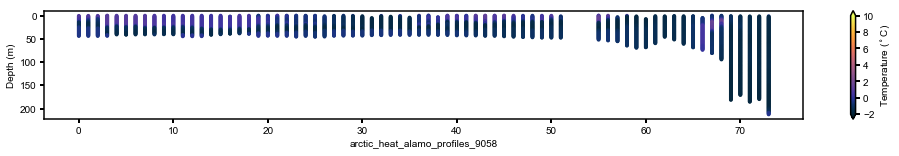

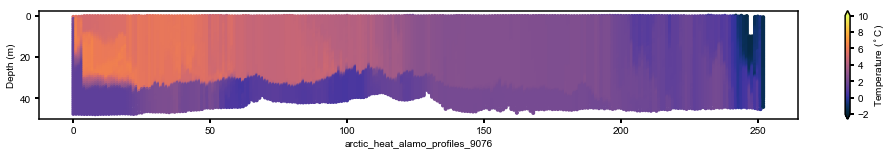

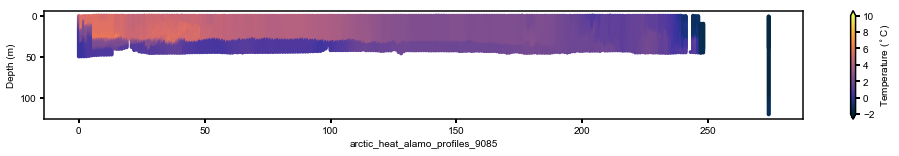

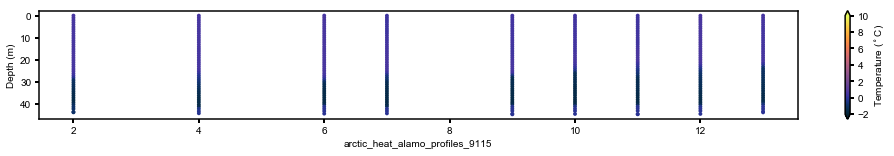

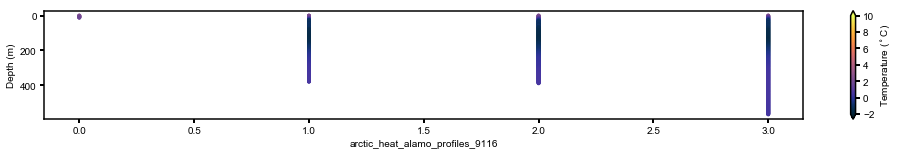

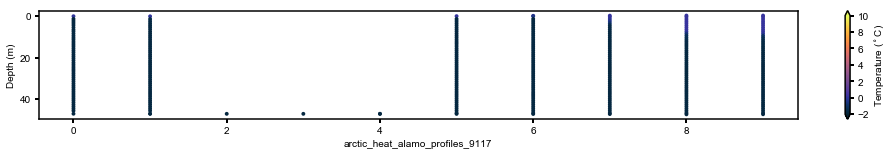

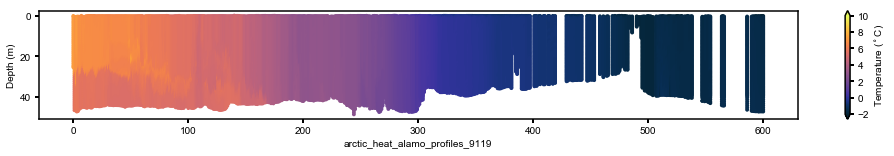

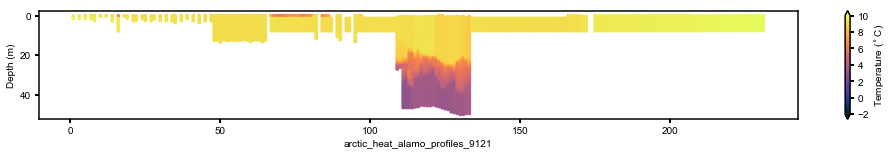

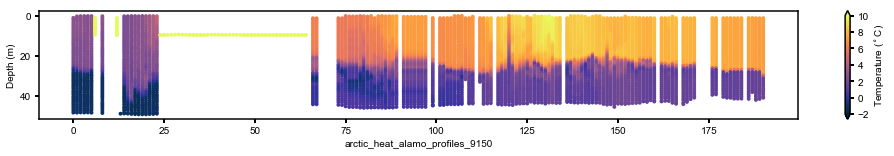

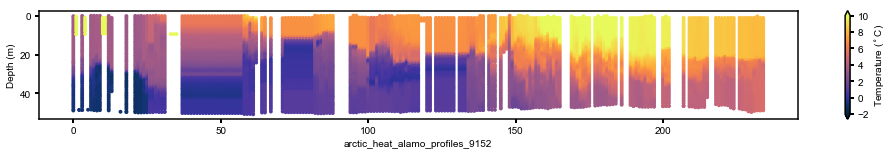

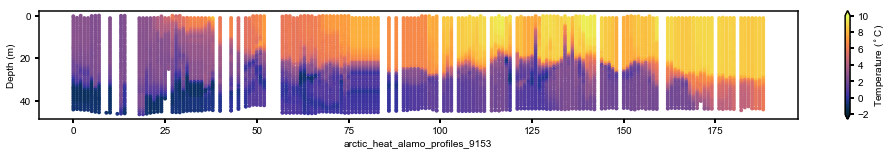

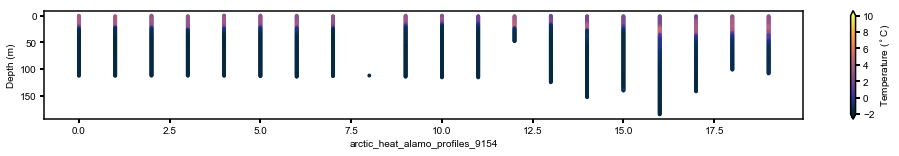

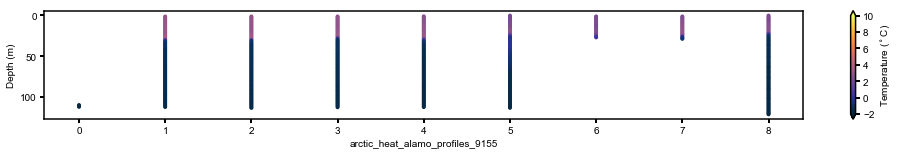

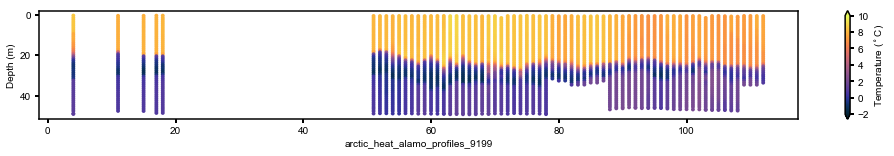

In [72]:
for dfn, df in dfs.items():
    fig, ax = plt.subplots(figsize=(17, 2))
    cs = ax.scatter(df['CYCLE_NUMBER'], df['PRES'], s=15, c=df['TEMP'], marker='o', edgecolor='none', vmin=-2, vmax=10, cmap=cmocean.cm.thermal)

    ax.invert_yaxis()
    #ax.set_xlim(df['CYCLE_NUMBER'][0], df['CYCLE_NUMBER'][-1])


    cbar = fig.colorbar(cs, orientation='vertical', extend='both')
    cbar.ax.set_ylabel('Temperature ($^\circ$C)')
    ax.set_ylabel('Depth (m)')
    ax.set_xlabel(dfn)

**Todo:** 
- Facets for TvS
- Sfc Temp
- Temp at Depth
- ~~~profiles~~~
- ~~~DepthAve temp / integrated heat~~~